In [1]:
%matplotlib inline

from pathlib import Path

import pandas as pd
import matplotlib.pylab as plt
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools
from dmba import regressionSummary

# 16.1
2001/9/11 테러로 인한 여파  
목적 : 9.11 테러 전후 장거리 여행 승객 수의 변화 알아보기 -> 1990/1 - 2004/5 사이의 매월 승객의 변화를 분석

In [40]:
sept11 = pd.read_csv("Sept11Travel.csv")
sept11

# AirRPM : 실제 항공기 유상여객 마일리지
# RailRM : 철도 승객 마일리지
# VMT_billions : 자동차 마일리지

,Month-Year,AirRPM,RailPM,VMT_billions
0,Jan-90,35153577,454115779,163.28
1,Feb-90,32965187,435086002,153.25
2,Mar-90,39993913,568289732,178.42
3,Apr-90,37981886,568101697,178.68
4,May-90,38419672,539628385,188.88
...,...,...,...,...
167,3-Dec,57795908,489403554,237.60
168,4-Jan,53447972,410338691,217.30
169,4-Feb,52608801,389778365,210.40
170,4-Mar,63600019,453014590,247.50


9/11 전의 데이터를 이용해서 미래의 데이터를 예측, 실제 데이터와 비교하여 9/11 사태의 여파를 살핌  
그를 위해 시계열 데이터를 9/11 전과 후로 나누고 첫 번째 데이터를 이용한다.

### a
예측적 분석이다

### b

In [ ]:
# Datetime으로 형변환

In [39]:
sept11.iloc[120:140]

,Month-Year,AirRPM,RailPM,VMT_billions
120,Jan-00,49745428,366607410,203.58
121,Feb-00,49876910,366139276,199.64
122,Mar-00,61378569,453096388,232.63
123,Apr-00,58981617,473751011,227.81
124,May-00,61165486,481725263,242.11
125,Jun-00,65524091,517102460,243.01
126,Jul-00,67883256,564747276,245.08
127,Aug-00,66924512,558060051,247.77
128,Sep-00,56441629,446489429,227.33
129,Oct-00,58834210,462329685,236.55


In [41]:
# datetime 형식으로 바꾸기 

form19 = "%b-%y"
form20 = "%y-%b"
sept11['Date'] = pd.to_datetime(sept11['Month-Year'].iloc[0:132], format = form19)
sept11['Month-Year'].iloc[132:172] = '0' + sept11['Month-Year'].iloc[132:172]
sept11['Date'].iloc[132:172] = pd.to_datetime(sept11['Month-Year'].iloc[132:172], format = form20)
sept11

/Users/JAE111/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Month-Year,AirRPM,RailPM,VMT_billions,Date
0,Jan-90,35153577,454115779,163.28,1990-01-01
1,Feb-90,32965187,435086002,153.25,1990-02-01
2,Mar-90,39993913,568289732,178.42,1990-03-01
3,Apr-90,37981886,568101697,178.68,1990-04-01
4,May-90,38419672,539628385,188.88,1990-05-01
...,...,...,...,...,...
167,03-Dec,57795908,489403554,237.60,2003-12-01
168,04-Jan,53447972,410338691,217.30,2004-01-01
169,04-Feb,52608801,389778365,210.40,2004-02-01
170,04-Mar,63600019,453014590,247.50,2004-03-01


In [96]:
# air/rail/car 시계열 데이터를 분할 및 series로 변환 

air = pd.Series(sept11.AirRPM.values, index=sept11.Date, name = 'Air')
rail = pd.Series(sept11.RailPM.values, index=sept11.Date, name = 'Rail')
car = pd.Series(sept11.VMT_billions.values, index=sept11.Date, name = 'Car')

In [97]:
# 인덱스를 DatetimeIndex로 형변환

air.index = pd.DatetimeIndex(air.index, freq = air.index.inferred_freq)
rail.index = pd.DatetimeIndex(rail.index, freq = rail.index.inferred_freq)
car.index = pd.DatetimeIndex(car.index, freq = car.index.inferred_freq)

Text(0, 0.5, 'Air')

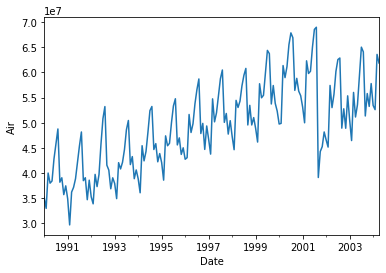

In [52]:
ax = air.plot()
ax.set_ylabel('Air')

Text(0, 0.5, 'Rail')

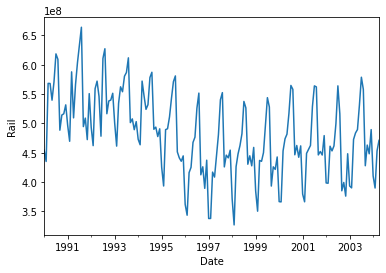

In [53]:
ax = rail.plot()
ax.set_ylabel('Rail')

Text(0, 0.5, 'Car')

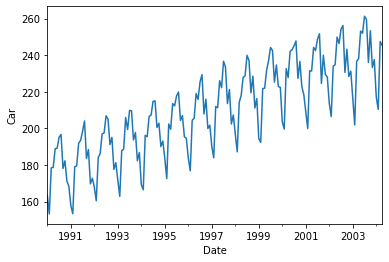

In [54]:
ax = car.plot()
ax.set_ylabel('Car')

### (i)
항공기 사용이 게속 증가하다가 2001년 이후로 급감하는 모습을 보였다.  
철도 사용은 1994년 기점으로 감소하다가 조금 증가한다.  
자동차는 꾸준히 증가하는 모습을 보인다.  

### (ii)

In [58]:
# 로그변환 

In [98]:
import numpy as np
air = air.map(np.log)
rail = rail.map(np.log)
car = car.map(np.log)
rail

Date
1990-01-01    19.933863
1990-02-01    19.891054
1990-03-01    20.158142
1990-04-01    20.157811
1990-05-01    20.106391
                ...    
2003-12-01    20.008698
2004-01-01    19.832493
2004-02-01    19.781089
2004-03-01    19.931435
2004-04-01    19.970616
Freq: MS, Name: Rail, Length: 172, dtype: float64

In [72]:
# 계절변동 감소 - 월간 데이터를 연간 데이터로

데이터 주기 변환 (resample 함수) 참고 : https://wikidocs.net/158101

In [99]:
air_y = air.resample(rule='1Y').mean()
rail_y = rail.resample(rule='1Y').mean()
car_y = car.resample(rule='1Y').mean()

In [76]:
rail_y

Date
1990-12-31    20.091590
1991-12-31    20.112716
1992-12-31    20.105623
1993-12-31    20.090186
1994-12-31    20.064352
1995-12-31    19.985307
1996-12-31    19.884436
1997-12-31    19.893141
1998-12-31    19.905815
1999-12-31    19.900309
2000-12-31    19.951758
2001-12-31    19.951485
2002-12-31    19.909848
2003-12-31    19.976231
2004-12-31    19.878908
Freq: A-DEC, Name: Rail, dtype: float64

In [78]:
# 각 시계열데이터에 추세선 추가 

In [100]:
air_tr = tsatools.add_trend(air_y, trend='ctt')
air_lm = sm.ols(formula='Air ~ trend + trend_squared',
                     data = air_tr).fit()

/Users/JAE111/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [101]:
rail_tr = tsatools.add_trend(rail_y, trend='ctt')
rail_lm = sm.ols(formula='Rail ~ trend + trend_squared',
                     data = rail_tr).fit()

In [102]:
car_tr = tsatools.add_trend(car_y, trend='ctt')
car_lm = sm.ols(formula='Car ~ trend + trend_squared',
                     data = car_tr).fit()

In [77]:
# plot

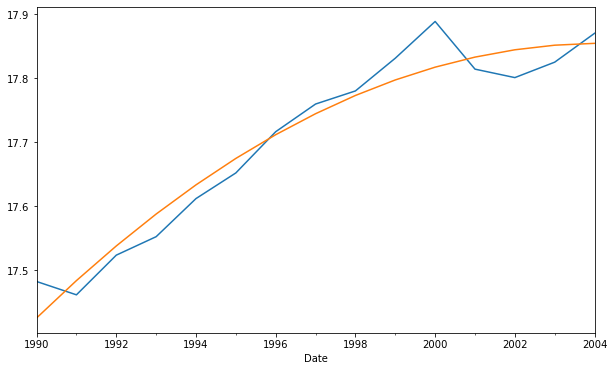

In [103]:
fig,axes = plt.subplots(figsize=(10,6))
air_y.plot()
#ax.set_ylim(1300, 2300)
air_lm.predict(air_tr).plot()
plt.show()

**air**
완만한 증가 추세 곡선

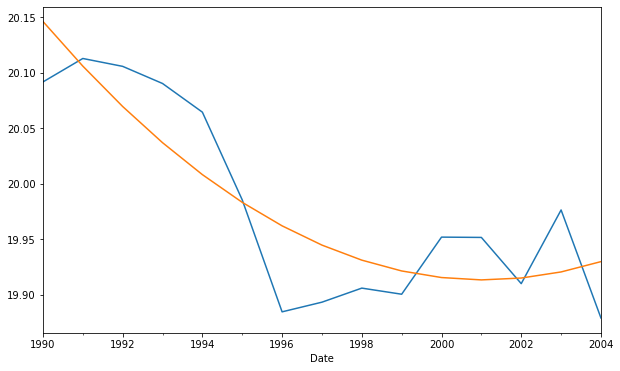

In [104]:
fig,axes = plt.subplots(figsize=(10,6))
rail_y.plot()
#ax.set_ylim(1300, 2300)
rail_lm.predict(rail_tr).plot()
plt.show()

**rail** 완만한 감소 곡선

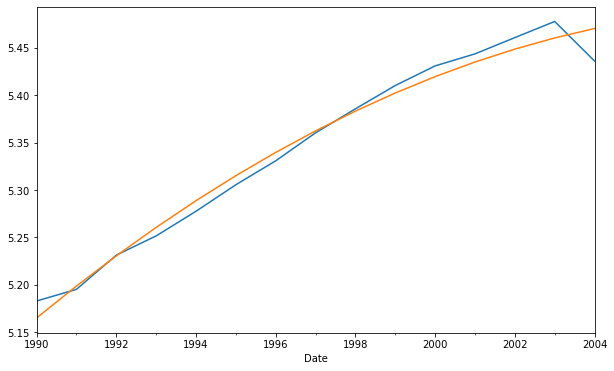

In [106]:
fig,axes = plt.subplots(figsize=(10,6))
car_y.plot()
#ax.set_ylim(1300, 2300)
car_lm.predict(car_tr).plot()
plt.show()

**car** 거의 (상향)직선에 가까운 추세 --> 로그 변환을 하였으므로 실제 데이터는 지수 함수에 가까운 곡선일 것 

In [ ]:
# 근데 log 변환을 하든 안 하든 걍 똑같은 추세를 보임... 뭐ㅈㅣ

# 16.2

### a
모델 A가 더 잘 설명하고 있다. 학습 데이터에 대한 RMSE가 모델 B보다 더 낮기 때문이다.   
(오차가 적다는 뜻이므로 학습 데이터에 대한 설명을 잘 하고 있고, 따라서 시계열의 요소를 잘 나타내는 모델이다.)

### b
모델 B가 더 좋다. 검증 데이터에 대한 RMSW가 모델 A보다 낮기 때문에, 새로운 데이터가 들어왔을 때 모델 B의 예측 오차가 더 작을 것이기 때문이다.

# 16.3

In [188]:
df = pd.read_csv("DepartmentStoreSales.csv")
df

,Quarter,Sales
0,1,50147
1,2,49325
2,3,57048
3,4,76781
4,5,48617
5,6,50898
6,7,58517
7,8,77691
8,9,50862
9,10,53028


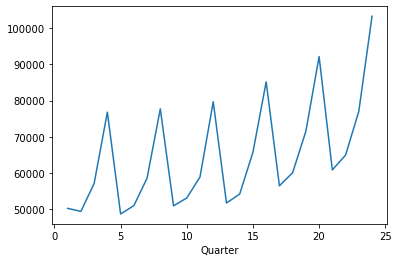

In [189]:
df = pd.Series(df.Sales.values, index=df.Quarter, name = 'df')
ax = df.plot()

### b
계절변동 : 일년마다 값이 급증하다가 년도가 바뀜에따라 급락한다.   
추세 : 점점 증가하고 있다.

# 16.4

In [190]:
df = pd.read_csv("ApplianceShipments.csv")
df

,Quarter,Shipments
0,Q1-1985,4009
1,Q2-1985,4321
2,Q3-1985,4224
3,Q4-1985,3944
4,Q1-1986,4123
5,Q2-1986,4522
6,Q3-1986,4657
7,Q4-1986,4030
8,Q1-1987,4493
9,Q2-1987,4806


In [158]:
for j in range(0,20,4):
    df.Quarter[j] =  df.Quarter[j].replace('Q1','03')
    df.Quarter[j+1] = df.Quarter[j+1].replace('Q2','06')
    df.Quarter[j+2] = df.Quarter[j+2].replace('Q3','09')
    df.Quarter[j+3] = df.Quarter[j+3].replace('Q4','12')

/var/folders/z6/j3q11gsn0ls8wtjzqj36nssm0000gp/T/ipykernel_2825/1344633627.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Quarter[j] =  df.Quarter[j].replace('Q1','03')
/var/folders/z6/j3q11gsn0ls8wtjzqj36nssm0000gp/T/ipykernel_2825/1344633627.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Quarter[j+1] = df.Quarter[j+1].replace('Q2','06')
/var/folders/z6/j3q11gsn0ls8wtjzqj36nssm0000gp/T/ipykernel_2825/1344633627.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [159]:
df

,Quarter,Shipments
0,03-1985,4009
1,06-1985,4321
2,09-1985,4224
3,12-1985,3944
4,03-1986,4123
5,06-1986,4522
6,09-1986,4657
7,12-1986,4030
8,03-1987,4493
9,06-1987,4806


In [160]:
df['Date'] = pd.to_datetime(df.Quarter, format = "%m-%Y")

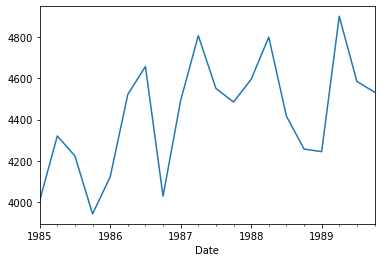

In [162]:
df = pd.Series(df.Shipments.values, index=df.Date, name = 'df')
df.index = pd.DatetimeIndex(df.index, freq = df.index.inferred_freq)
ax = df.plot()

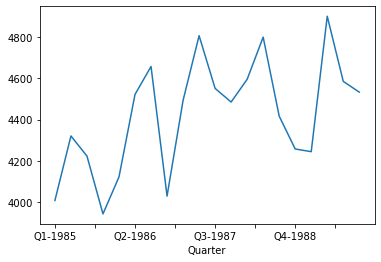

In [191]:
# datetime 변환 안 하고 바로 시계열 plot해도 되는구낭

df = pd.Series(df.Shipments.values, index=df.Quarter, name = 'df')
ax = df.plot()

### b
추세 : 점점 증가한다.  
계절변동 : 값이 늘다가 3분기마다 값이 급락하고, 다시 4분기부터 2분기까지 증가한다. 

# 16.5

In [165]:
df = pd.read_csv("CanadianWorkHours.csv")
df

,Year,Hours
0,1966,37.2
1,1967,37.0
2,1968,37.4
3,1969,37.5
4,1970,37.7
5,1971,37.7
6,1972,37.4
7,1973,37.2
8,1974,37.3
9,1975,37.2


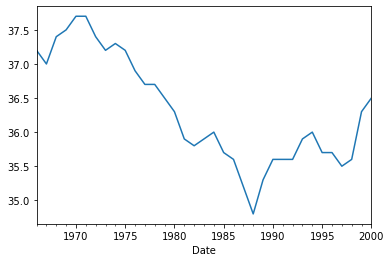

In [167]:
df['Date'] = pd.to_datetime(df.Year, format = "%Y")
df = pd.Series(df.Hours.values, index=df.Date, name = 'df')
df.index = pd.DatetimeIndex(df.index, freq = df.index.inferred_freq)
ax = df.plot()

### b
추세 : 1988년도쯤에서 극솟값을 가지는 이차곡선의 모형  
계절변동 : 크게 두드러지지 않는다.

# 16.6

### a

In [14]:
sales = pd.read_csv("SouvenirSales.csv",encoding="koi8-r")
sales = sales.iloc[:,0:2]
sales

,Date,Sales
0,Jan-95,1664.81
1,Feb-95,2397.53
2,Mar-95,2840.71
3,Apr-95,3547.29
4,May-95,3752.96
...,...,...
79,Aug-01,28586.52
80,Sep-01,30505.41
81,Oct-01,30821.33
82,Nov-01,46634.38


In [15]:
sales['format_Date'] = pd.to_datetime(sales.Date, format = "%b-%y")

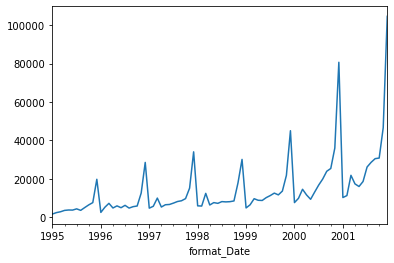

In [16]:
sales = pd.Series(sales.Sales.values, index = sales.format_Date, name = 'sales')
sales.index = pd.DatetimeIndex(sales.index, freq = sales.index.inferred_freq)
ax = sales.plot()

### b

In [17]:
import numpy as np

# y축 변경
sales_log = sales.map(np.log) 

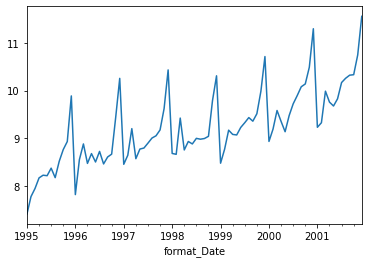

In [18]:
ax = sales_log.plot()

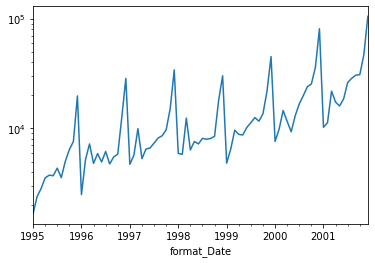

In [30]:
# 저렇게 일일이 변형 안 해도 plt.yscale("log") 함수를 이용해서 로그함수 그릴 수 있다. 

ax = sales.plot()
plt.yscale("log")
plt.show()

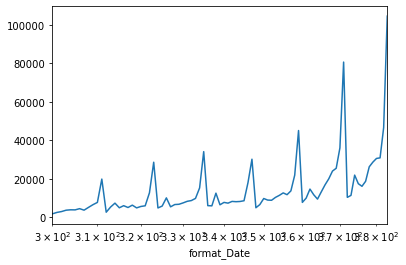

In [29]:
# x축변경
ax = sales.plot()
plt.xscale("log")
plt.show()

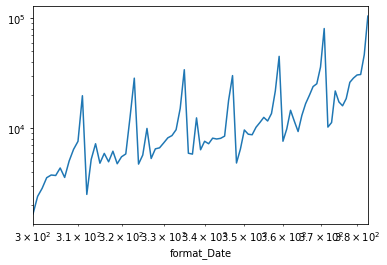

In [31]:
# 둘 다 변경
ax = sales.plot()
plt.yscale("log")
plt.xscale("log")
plt.show()

y축 로그변경이 가장 선형성을 띈다

# 16.7

In [193]:
shampoo = pd.read_csv("ShampooSales.csv",encoding="ISO-8859-1")
shampoo

,Month,Shampoo Sales
0,éðå-95,266.0
1,ôáø-95,145.9
2,îøõ-95,183.1
3,àôø-95,119.3
4,îàé-95,180.3
5,éåð-95,168.5
6,éåì-95,231.8
7,àåâ-95,224.5
8,ñôè-95,192.8
9,àå÷-95,122.9


In [182]:
def ensure_unicode(v):
    if isinstance(v, str):
        v = v.decode('utf8')
    return unicode(v)  # convert anything not a string to unicode too

output_string = u'\n'.join([ensure_unicode(line) for line in output_lines])

NameError: name 'output_lines' is not defined

# 6,7번 둘 다 인코딩이 안됩니다 ㅠㅠㅠㅠㅠㅠㅠㅠ 구글링해서 웬만한 인코딩 다 써봣는데 다 안돼요 ㅠㅠㅠㅜ 혹시 성공하신 분들 있으시면 알려주세요 